# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../data/pre_processed_tox_padel_no_inputation.csv")
data.head()

/tmp/ipykernel_866234/3169484179.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/pre_processed_tox_padel_no_inputation.csv")


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,AMW,XLogP,fda_approved
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,6.560927,-0.646,1.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,7.503203,-0.728,1.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,8.447475,-1.606,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.000000e+00,0.000000e+00,8.452347e+00,2.113087,0.0,7.002720,0.106,1.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,7.801394,-0.786,1.0


In [4]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: fda_approved, dtype: float64

In [5]:
X = data.iloc[:, 32:-1]
X.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,nS,...,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,AMW,XLogP
0,-2.775558e-17,-0.4695,0.220430,11.1997,8.393965,0.0,2.168404e-19,3.0,0.0,0.0,...,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,6.560927,-0.646
1,-2.775558e-17,-1.0852,1.177659,15.4305,9.557965,0.0,2.168404e-19,1.0,2.0,0.0,...,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,7.503203,-0.728
2,-2.775558e-17,-1.0880,1.183744,12.5072,8.231172,0.0,2.168404e-19,2.0,2.0,0.0,...,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,8.447475,-1.606
3,-2.775558e-17,-0.2157,0.046526,22.3381,12.187551,0.0,2.168404e-19,1.0,0.0,1.0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.452347e+00,2.113087,0.0,7.002720,0.106
4,-2.775558e-17,-0.5895,0.347510,11.3934,11.222758,0.0,2.168404e-19,0.0,1.0,1.0,...,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,7.801394,-0.786


In [6]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "padel_no_inputation"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,...,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,AMW,XLogP
0,1.0,-0.384264,0.788865,-0.229143,-0.291880,-0.408304,-0.211106,-0.037682,-0.435561,-0.735215,...,0.246937,-1.135013,-0.949080,-0.572293,-0.469708,-0.243633,-0.268681,-0.764268,-0.291935,0.152604
1,1.0,-0.384264,0.770832,-0.234987,-0.501520,-0.550595,-0.211106,-0.037682,-0.435561,-1.082916,...,0.357869,1.690379,-0.949080,-0.489304,-0.242995,-0.243701,-0.268741,-0.764268,-0.623531,0.497794
2,1.0,4.704976,-0.739232,-0.028694,1.558303,1.341525,1.416469,-0.037682,3.170735,1.698697,...,0.322202,0.846683,0.930407,-0.277880,-0.698558,-0.243268,-0.268622,1.491724,0.875443,-1.103983
3,1.0,-0.384264,0.768121,-0.235849,0.828757,0.183524,-1.187651,-0.037682,-0.950746,-0.387513,...,1.270237,1.601681,1.164713,0.035497,0.006079,-0.243600,-0.268690,1.012573,-0.565028,0.059655
4,1.0,-0.384264,0.156141,-0.316932,-0.832334,-1.063274,-0.373863,-0.037682,1.109995,0.307890,...,2.498197,-1.135013,-0.949080,0.390482,1.223192,-0.243697,-0.268736,1.012573,0.663422,-0.806688


In [9]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,...,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,AMW,XLogP
0,1.0,-0.365136,-0.481194,-0.157995,-0.704974,-0.634820,-0.227894,-0.056553,-0.424318,-0.401963,...,0.859278,2.201779,-0.908317,0.650141,1.730294,-0.247267,-0.262206,-0.806342,-0.352875,-0.120580
1,1.0,1.255587,-1.354054,0.439313,1.720948,1.207457,-1.134014,-0.056553,-0.898525,2.033854,...,0.443293,0.513767,0.587013,1.981764,1.033580,-0.247046,-0.262191,2.152805,-0.446278,-0.199650
2,1.0,-0.365136,-0.201262,-0.254344,-0.268959,0.769209,1.584346,-0.056553,-0.424318,-0.053990,...,-0.535671,0.015323,-0.200149,0.816602,0.358385,-0.247089,-0.262193,0.998348,-0.278036,1.746965
3,1.0,-0.365136,-0.964573,0.117240,-0.965918,-0.421669,0.678226,-0.056553,-0.898525,0.989932,...,0.442453,2.647868,-0.014566,0.486162,0.619565,-0.246989,-0.262074,-0.806342,0.382815,-0.708819
4,1.0,-0.365136,-0.101275,-0.277551,-0.824721,-0.791159,-0.227894,-0.056553,0.049890,-1.097911,...,-1.248377,-1.058108,-0.908317,-0.854790,-0.947360,-0.247337,-0.262262,0.998348,-0.349477,0.041106


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 12:46


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 12:47
Tempo de execução:  0.2 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.731352,{}


## Calculating Logistic Regression in R

## Saving Datasets to use in R

The logistic regression calculation was presenting problems in Python, so it will be performed in R, in a separate notebook, saved in the folder `logistic_regression`. Here, I will save the training and test datasets, to use them in R.

In [14]:
# reseting indices
x_train_scaled = x_train_scaled.reset_index()
x_test_scaled = x_test_scaled.reset_index()

y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [15]:
# joining x and y training and test datasets
train = pd.concat([x_train_scaled, y_train], axis=1).drop(["index"], axis=1)
test = pd.concat([x_test_scaled, y_test], axis=1).drop(["index"], axis=1)

In [16]:
# saving datasets
train.to_csv(f"logistic_regression/data/train_{DESCRIPTOR_TYPE}.csv")
test.to_csv(f"logistic_regression/data/test_{DESCRIPTOR_TYPE}.csv")

## Importing results from R

In [17]:
results_log_reg_df = pd.read_csv(f"logistic_regression/data/lr_coefficients_{DESCRIPTOR_TYPE}.csv")
results_log_reg_df.head()

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,(Intercept),-7.956213e+13,2.780024e+06,-2.861922e+07,0
1,X,-5.168332e+10,1.756244e+03,-2.942833e+07,0
2,nAcid,1.784657e+14,4.566905e+06,3.907804e+07,0
3,ALogP,-9.434659e+13,7.857896e+06,-1.200660e+07,0
4,ALogp2,-9.308066e+13,4.802626e+06,-1.938120e+07,0


In [18]:
# y predict in test set
y_predict_lr_prob = pd.read_csv(f"logistic_regression/data/y_predict_proba_test_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob = y_predict_lr_prob["x"]
y_predict_lr_prob.head()

0    1.000000e+00
1    1.000000e+00
2    2.220446e-16
3    1.000000e+00
4    1.000000e+00
Name: x, dtype: float64

In [19]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

In [20]:
# y predict in training set
y_predict_lr_prob_train = pd.read_csv(f"logistic_regression/data/y_predict_proba_train_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob_train = y_predict_lr_prob_train["x"]
y_predict_lr_prob_train.head()

0    2.220446e-16
1    1.000000e+00
2    1.000000e+00
3    1.000000e+00
4    2.220446e-16
Name: x, dtype: float64

## Get Training Error and AUC

In [21]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=y_predict_lr_prob_train, 
    x=x_train_scaled,
    y_true=y_train["fda_approved"],
    transform_prob_into_label=True,
    log_reg=True
)

Training Misclassification Rate: 0.2595
Training AUC: 0.7405


## Test Error

In [22]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test["fda_approved"], 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.4623


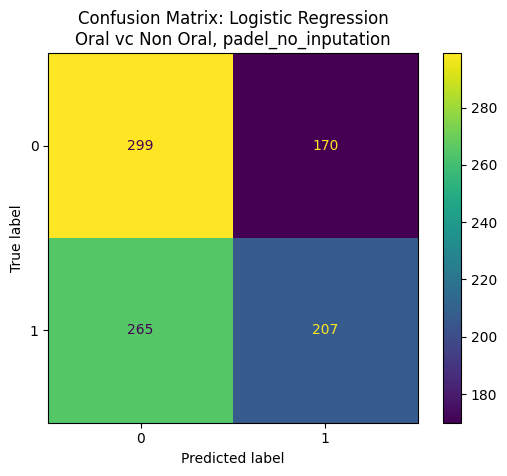

In [23]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

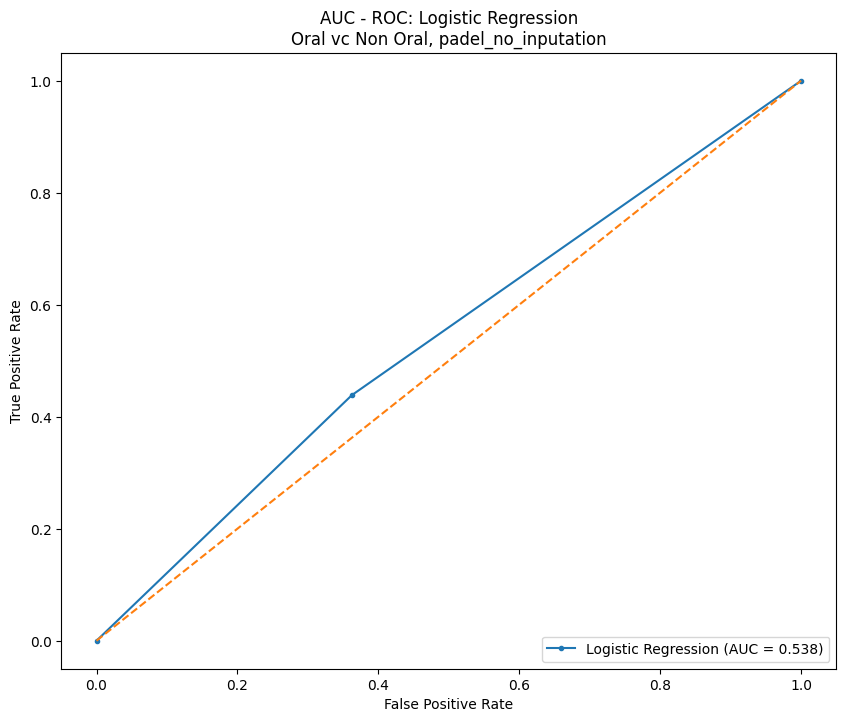

In [24]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test["fda_approved"],
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [25]:
# converting results summary to pandas dataframe
results_log_reg_df = results_log_reg_df.rename(columns={"Unnamed: 0": "descriptor_name"})
results_log_reg_df = results_log_reg_df.set_index(results_log_reg_df["descriptor_name"]).drop("descriptor_name", axis=1)
results_log_reg_df.shape
results_log_reg_df.head()

,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
(Intercept),-7.956213e+13,2.780024e+06,-2.861922e+07,0
X,-5.168332e+10,1.756244e+03,-2.942833e+07,0
nAcid,1.784657e+14,4.566905e+06,3.907804e+07,0
ALogP,-9.434659e+13,7.857896e+06,-1.200660e+07,0
ALogp2,-9.308066e+13,4.802626e+06,-1.938120e+07,0


In [26]:
important_features_lr = results_log_reg_df[results_log_reg_df["Pr(>|z|)"] < 0.05]
important_features_lr = important_features_lr.reindex(important_features_lr['Estimate'].abs().sort_values(ascending=False).index)
print(important_features_lr.shape)
important_features_lr

(607, 4)


,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
ETA_Epsilon_2,7.032896e+17,3.879533e+10,1.812820e+07,0
ETA_Epsilon_5,-6.422226e+17,3.551260e+10,-1.808436e+07,0
ETA_dEpsilon_D,-3.089857e+17,1.708073e+10,-1.808973e+07,0
nHsOH,1.052579e+16,3.605677e+08,2.919226e+07,0
ATS0s,-9.478454e+15,8.312048e+08,-1.140327e+07,0
...,...,...,...,...
ETA_dAlpha_B,1.870313e+12,1.416696e+07,1.320193e+05,0
nF6HeteroRing,-1.415419e+12,2.956174e+06,-4.788009e+05,0
SpMin7_Bhe,8.363422e+11,6.302957e+06,1.326904e+05,0


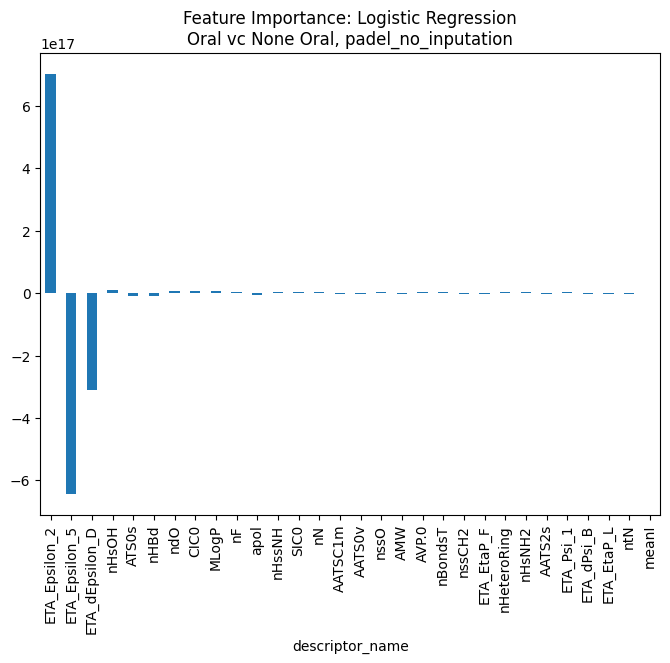

In [27]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

important_features_lr.iloc[:30,0].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

## Saving Results

In [28]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [29]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.731352,0.259482,0.462274,0.740454,0.538043


In [30]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [27]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [28]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [29]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Decision Tree: 09:36
Finished Grid Search for Decision Tree: 10:25
Tempo de execução:  49.2 minutos


In [30]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.736386,"{'ccp_alpha': 0.0001, 'criterion': 'log_loss',..."


## Fitting Tree

In [31]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0.0001, 'criterion': 'log_loss', 'max_depth': 5}

In [32]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [33]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.2609
Training AUC: 0.7392


## Make Predictions

In [34]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [35]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.3454


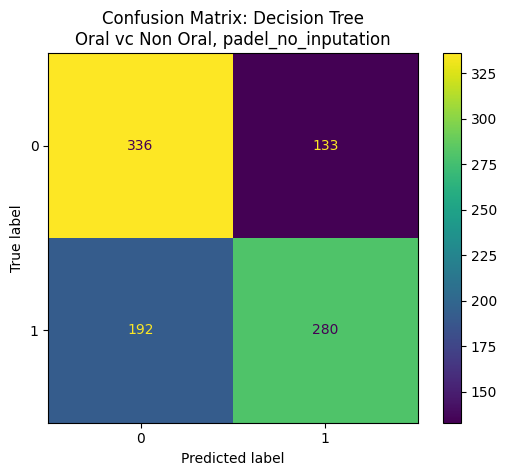

In [36]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

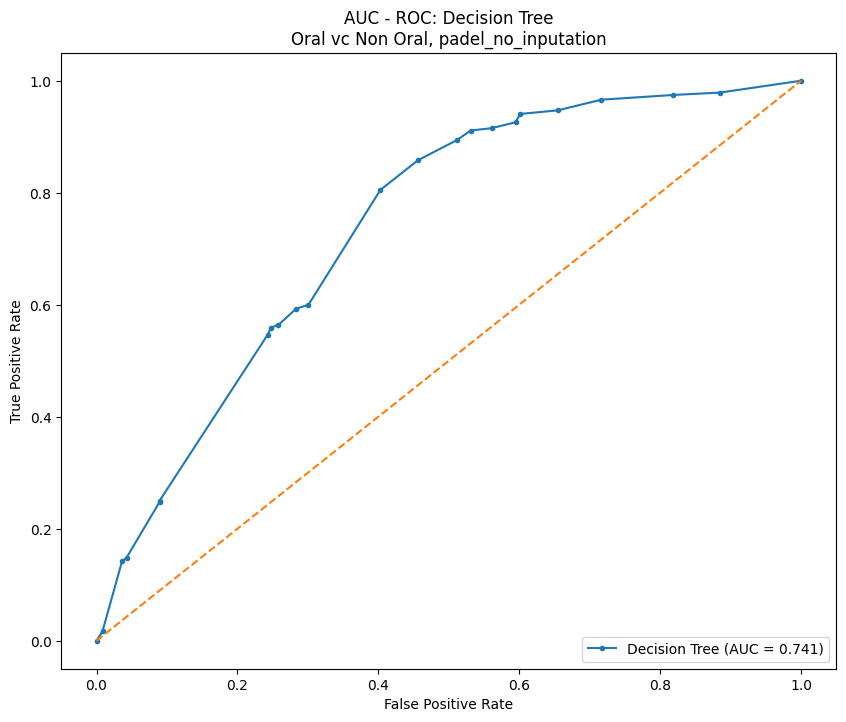

In [37]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

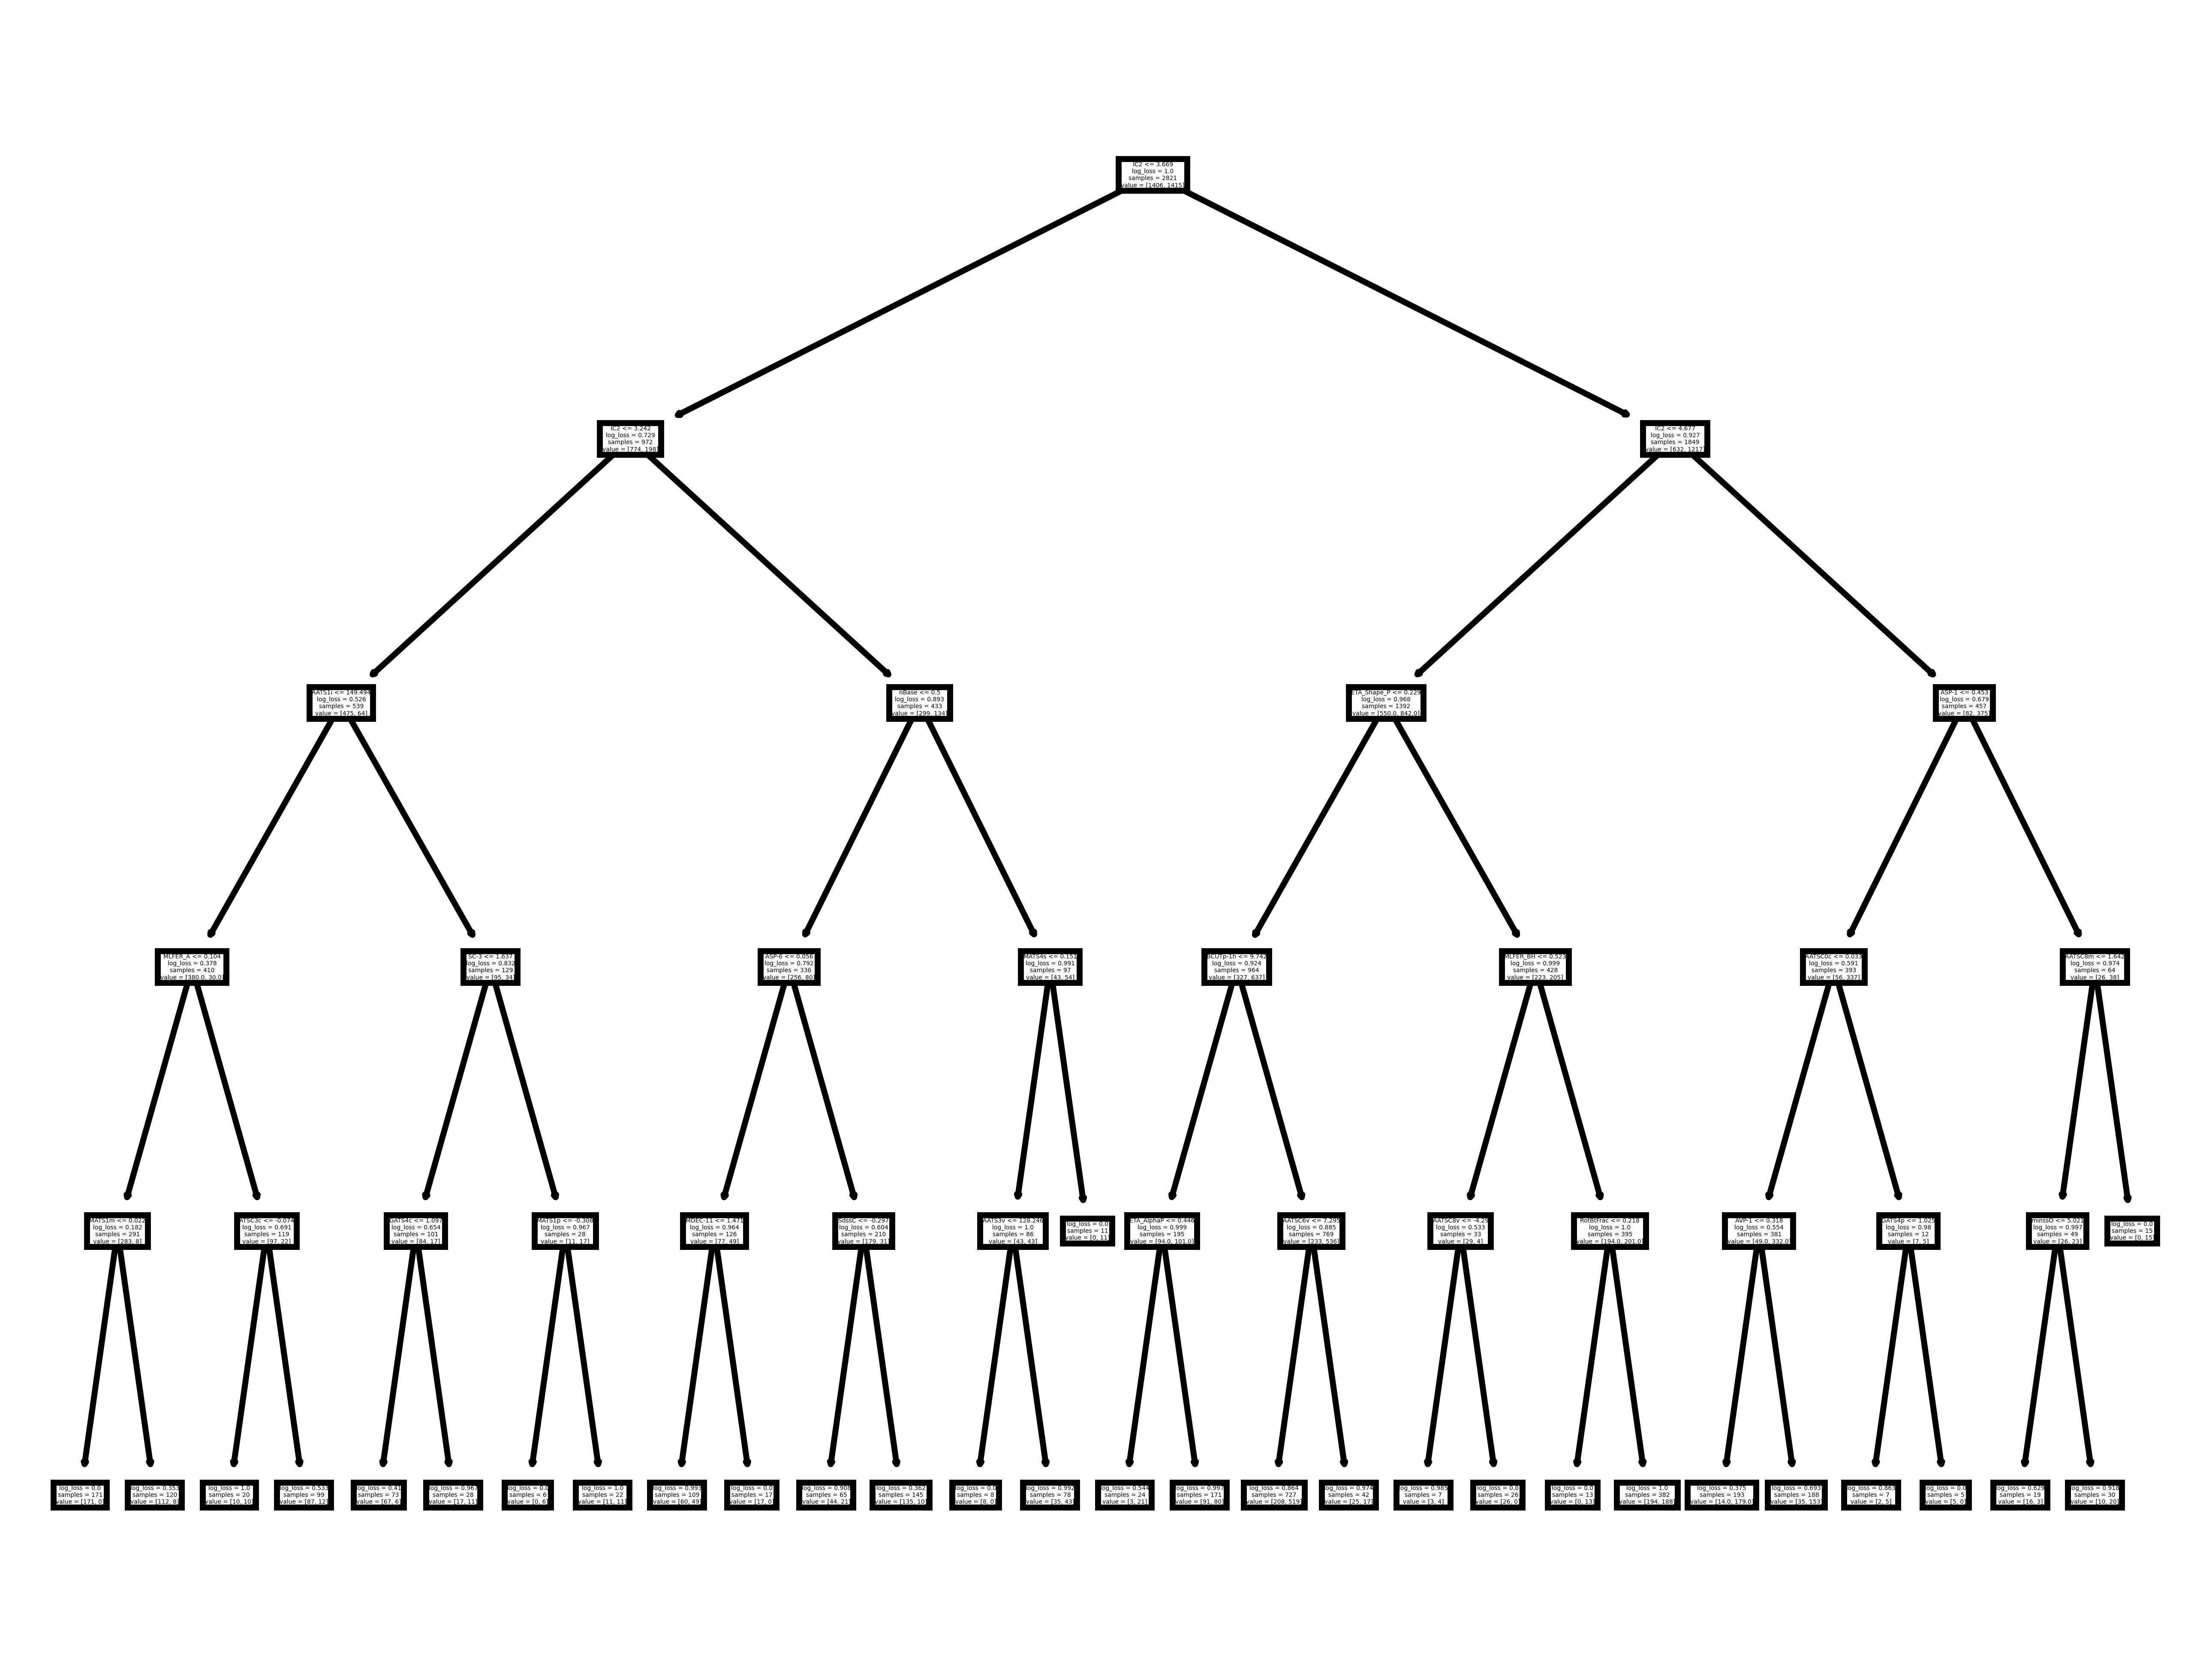

In [38]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

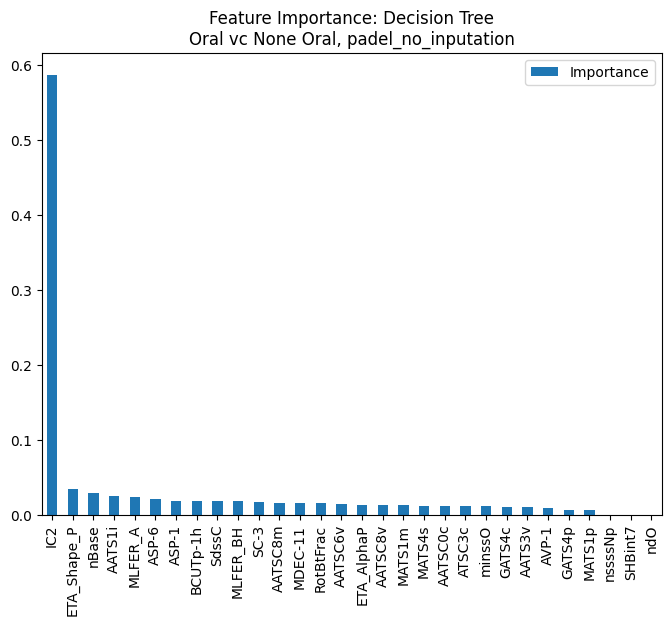

In [39]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [40]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
MATS1p,0.006028
GATS4p,0.006803
AVP-1,0.009675
AATS3v,0.010226
GATS4c,0.010774
minssO,0.011143
ATSC3c,0.011227
AATSC0c,0.011275
MATS4s,0.012018
MATS1m,0.012445


## Saving Results

In [41]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.731352,0.20241,0.317747,0.797439,0.728059
1,Decision Tree,0.736386,0.26090,0.345377,0.739228,0.740929


In [42]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [43]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [44]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2"], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5]
        }
    }
}

In [45]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Random Forest: 10:25
Finished Grid Search for Random Forest: 14:42
Tempo de execução:  257.2 minutos


In [46]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.757041,"{'ccp_alpha': 0, 'max_depth': 10, 'max_feature..."


## Fitting Model

In [47]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}

In [48]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [49]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.1166
Training AUC: 0.8831


## Make Predictions

In [50]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [51]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.3082


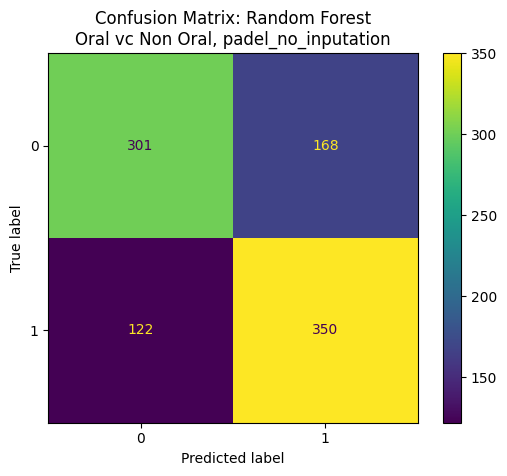

In [52]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

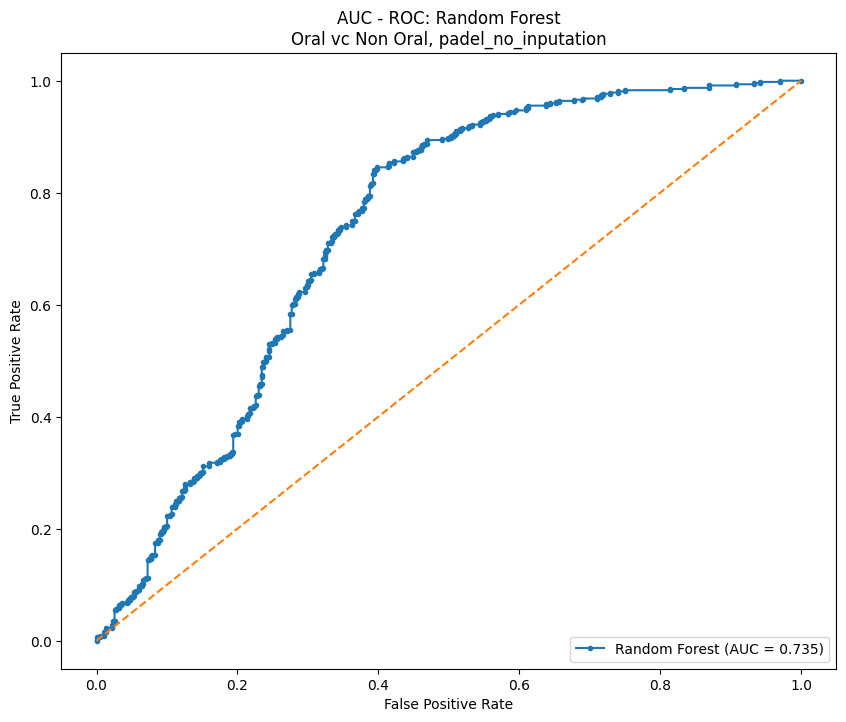

In [53]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

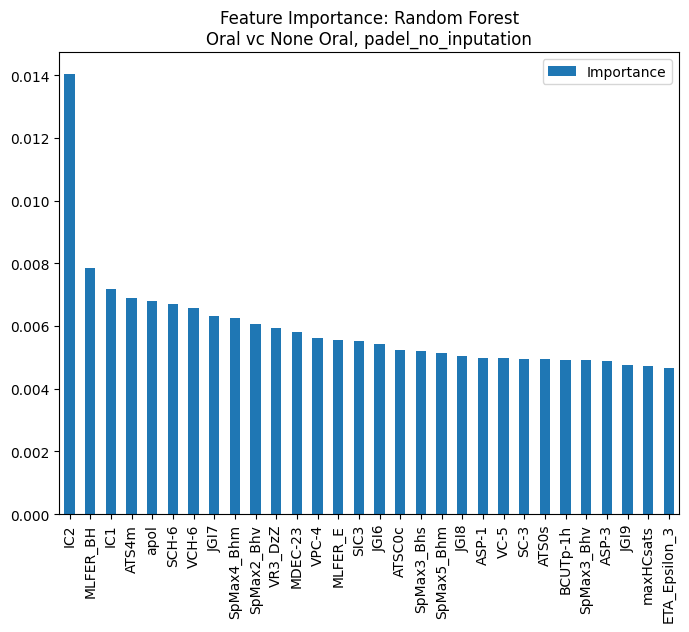

In [54]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [55]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
maxdS,0.000001
n9Ring,0.000002
ndsssAs,0.000002
minssssSi,0.000004
nF12Ring,0.000008
...,...
apol,0.006803
ATS4m,0.006900
IC1,0.007185
MLFER_BH,0.007847


## Saving Results

In [56]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.731352,0.202410,0.317747,0.797439,0.728059
1,Decision Tree,0.736386,0.260900,0.345377,0.739228,0.740929
2,Random Forest,0.757041,0.116625,0.308183,0.883103,0.735413


In [57]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [58]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [59]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500], # number of trees
                'learning_rate': [0.01, 0.1], # alfa
                'max_depth': [20],
        }
    }
}

In [60]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 14:42
Finished Grid Search for Boosting: 01:27
Tempo de execução:  644.6 minutos


In [61]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.663784,"{'learning_rate': 0.1, 'max_depth': 20, 'n_est..."


## Fitting Model

In [62]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}

In [63]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [64]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0567
Training AUC: 0.9432


## Make Prediction

In [65]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [66]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.3486


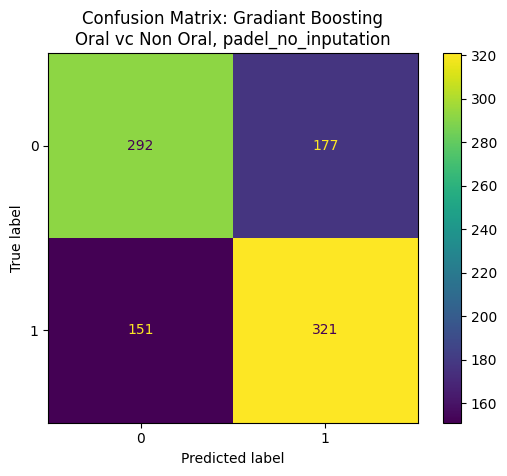

In [67]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

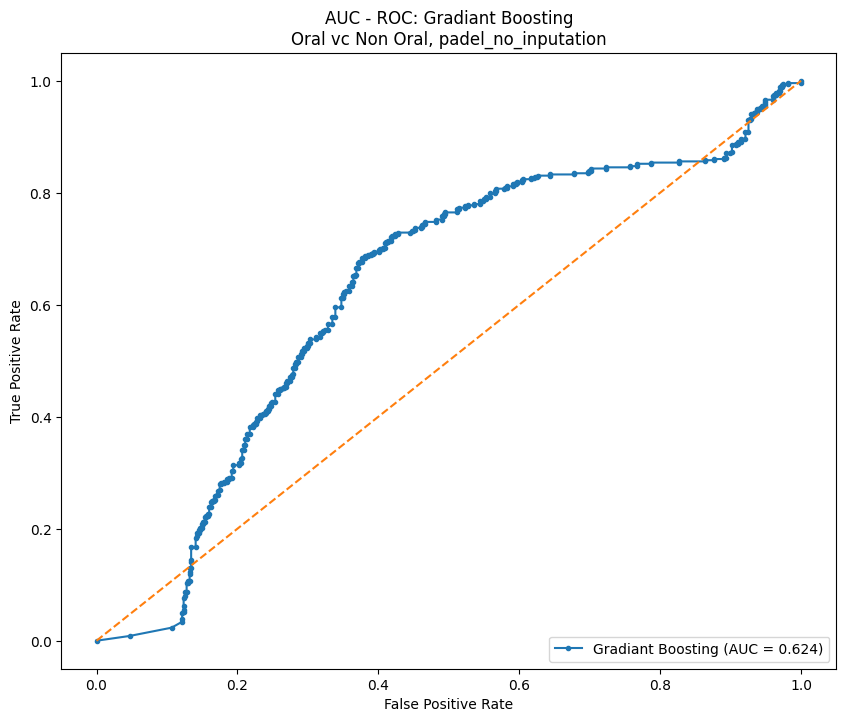

In [68]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

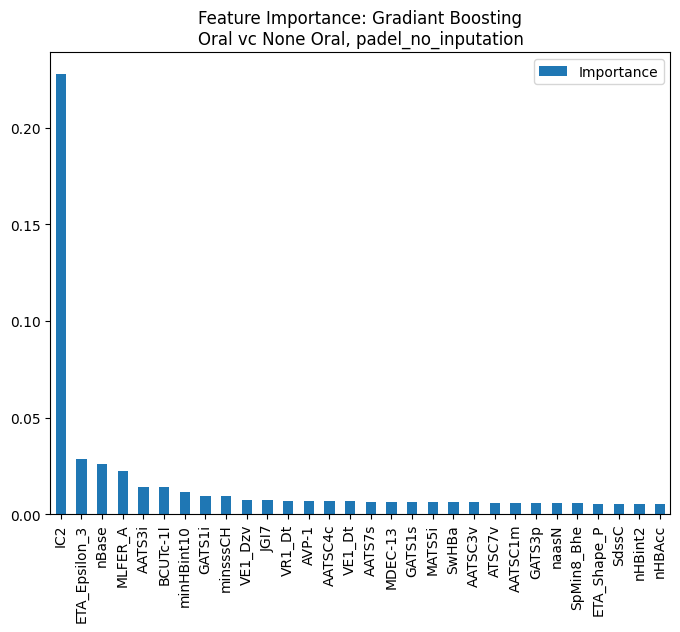

In [69]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [70]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
n8Ring,3.506627e-34
nHtCH,6.781902e-34
nF7HeteroRing,4.218270e-27
nB,4.525434e-27
nHsSH,8.255165e-25
...,...
AATS3i,1.417213e-02
MLFER_A,2.211631e-02
nBase,2.599234e-02
ETA_Epsilon_3,2.857610e-02


## Saving Results

In [71]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.731352,0.202410,0.317747,0.797439,0.728059
1,Decision Tree,0.736386,0.260900,0.345377,0.739228,0.740929
2,Random Forest,0.757041,0.116625,0.308183,0.883103,0.735413
3,Gradiant Boosting,0.663784,0.056717,0.348565,0.943230,0.624300


In [72]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [73]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [74]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [75]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [76]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 01:41
Finished Grid Search for BART: 07:47
Tempo de execução:  365.5 minutos


In [77]:
gs_result_bart

,model,best_score,best_params
0,BART,0.726933,"{'burnin': 10, 'max_stages': 100, 'num_trees':..."


# Fitting Model

In [78]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 10, 'max_stages': 100, 'num_trees': 1000}

In [79]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=10, max_stages=100, num_trees=1000)

## Get Training Error and AUC

In [80]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.2400
Training AUC: 0.7598


## Make Prediction

In [81]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [82]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [83]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.2859


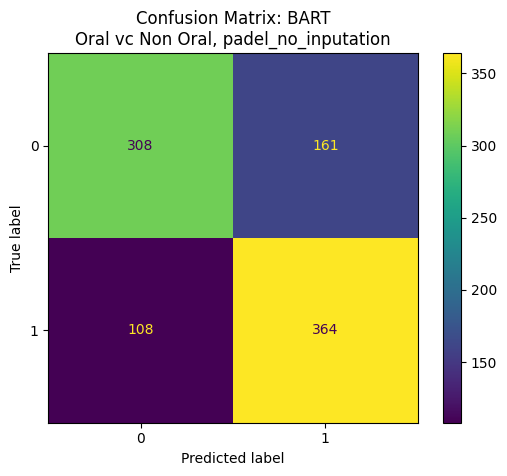

In [84]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

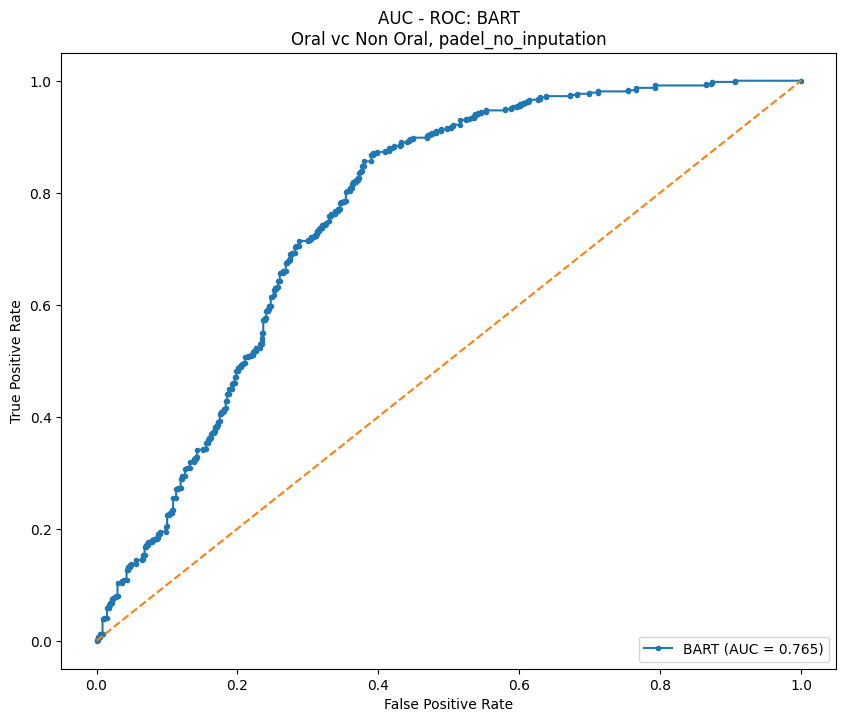

In [85]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

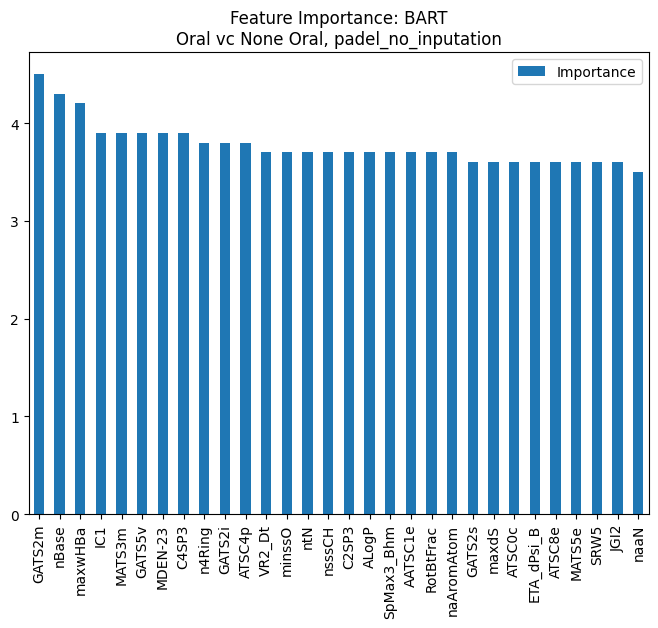

In [86]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [87]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
GATS4m,1.0
AVP-0,1.1
minsCH3,1.2
AATSC1s,1.3
AATSC4e,1.4
...,...
MATS3m,3.9
IC1,3.9
maxwHBa,4.2
nBase,4.3


## Saving Results

In [88]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.731352,0.202410,0.317747,0.797439,0.728059
1,Decision Tree,0.736386,0.260900,0.345377,0.739228,0.740929
2,Random Forest,0.757041,0.116625,0.308183,0.883103,0.735413
3,Gradiant Boosting,0.663784,0.056717,0.348565,0.943230,0.624300
4,BART,0.726933,0.239986,0.285866,0.759809,0.764559


In [89]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [90]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [91]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [92]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 07:48
Finished Grid Search for SVM: 11:27
Tempo de execução:  218.8 minutos


## Fitting Model

In [93]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 5, 'gamma': 1.1207106165211825e-13, 'kernel': 'rbf'}

In [94]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [95]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.4350
Training AUC: 0.5638


## Make Prediction

In [96]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [97]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.4431


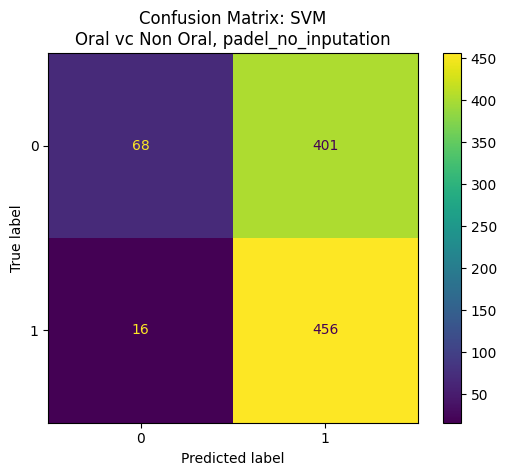

In [98]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

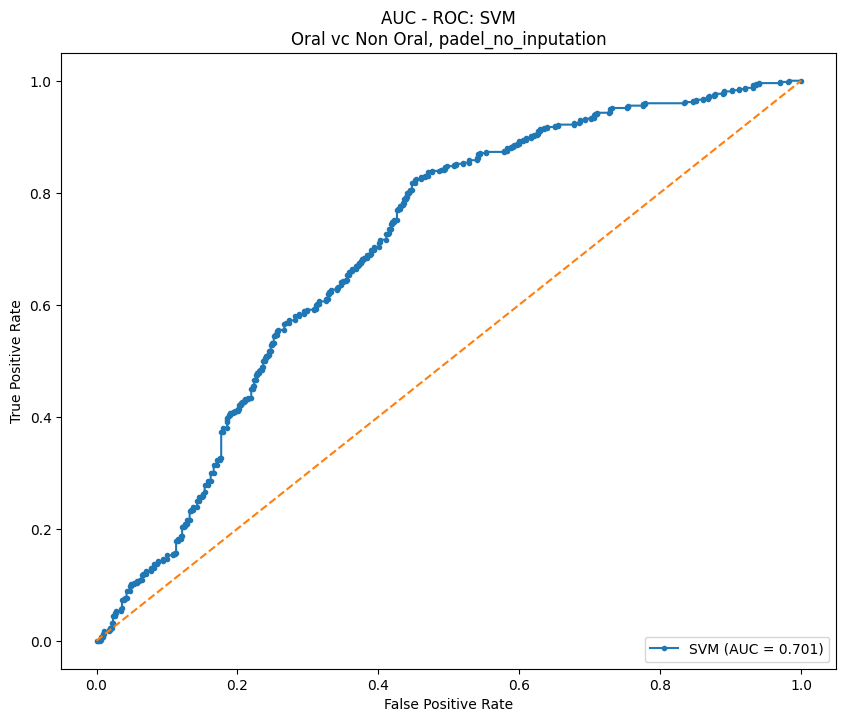

In [99]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [100]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.731352,0.202410,0.317747,0.797439,0.728059
1,Decision Tree,0.736386,0.260900,0.345377,0.739228,0.740929
2,Random Forest,0.757041,0.116625,0.308183,0.883103,0.735413
3,Gradiant Boosting,0.663784,0.056717,0.348565,0.943230,0.624300
4,BART,0.726933,0.239986,0.285866,0.759809,0.764559
5,SVM,0.732352,0.434952,0.443146,0.563755,0.700539


# Saving Final Datasets

In [101]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [102]:
session_info.show()